# Import

In [1]:
import json
import pathlib
import sys
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

sys.path.append(pathlib.Path.cwd().parent.as_posix())
from src.data.preprocess.lib.utils import get_patient_split

# Path

In [2]:
project_root = pathlib.Path.cwd().parent
gated_root = list(project_root.rglob("Gated*"))[0]
clean_json_path = list(project_root.rglob("clean*.json"))[0]

# Finding class distribution

In [3]:
# Split the patients into training, validation, and test sets
split_dict = get_patient_split([0.7, 0.2, 0.1])

# Initialize the EDA (Exploratory Data Analysis) dictionary
eda_dict = {}

# Get the project root directory
project_root = pathlib.Path.cwd().parent

# Find the 'Gated*' directory
gated_root = next(project_root.rglob("Gated*"))

# Find the 'clean*.json' file
clean_json_path = next(project_root.rglob("clean*.json"))

# Calculate total dcm and pixel counts for each split
for split_name, patient_list in split_dict.items():
    total_dcm = 0
    for patient in tqdm(patient_list):
        # Remove leading zeros from patient ID
        lstrip_patient = patient.lstrip("0") if patient != "000" else "0"

        # Find the patient's root directory
        patient_root = next(gated_root.rglob(lstrip_patient))

        # Count the number of dcm files
        total_dcm += len(list(patient_root.rglob("*.dcm")))

    # Store the total dcm and pixel counts in the EDA dictionary
    eda_dict[split_name + "_dcm"] = total_dcm
    eda_dict[split_name + "_pixel"] = total_dcm * 512 * 512

# Calculate the total dcm and pixel counts for the entire dataset
for label in ["dcm", "pixel"]:
    eda_dict[f"total_{label}"] = sum(
        value for key, value in eda_dict.items() if label in key
    )

# Load the data from the clean JSON file
with clean_json_path.open(mode="r") as f:
    clean_dict = json.load(f)

    # Process each patient's images and lesions
    for patient_num, images in tqdm(clean_dict.items()):
        for split_name, split_list in split_dict.items():
            if patient_num in split_list:
                for image in images:
                    for lesion in image["roi"]:
                        label = lesion["loc"]
                        n_pos = len(lesion["pos"])

                        # Generate keys for pixel and percent values
                        total_pixel_key = f"total_{label}_pixel"
                        total_percent_key = f"total_{label}_percent"
                        total_bg_pixel_key = "total_bg_pixel"
                        total_bg_percent_key = "total_bg_percent"
                        split_pixel_key = f"{split_name}_{label}_pixel"
                        split_bg_pixel_key = f"{split_name}_bg_pixel"
                        split_percent_key = f"{split_name}_{label}_percent"
                        split_bg_percent_key = f"{split_name}_bg_percent"

                        # Update pixel and percent values

                        eda_dict[total_bg_pixel_key] = (
                            eda_dict.get(total_bg_pixel_key, eda_dict["total_pixel"])
                            - n_pos
                        )
                        eda_dict[total_bg_percent_key] = (
                            eda_dict.get(total_bg_percent_key, 100)
                            - (n_pos / eda_dict["total_pixel"]) * 100
                        )
                        eda_dict[split_bg_pixel_key] = (
                            eda_dict.get(
                                split_bg_pixel_key, eda_dict[split_name + "_pixel"]
                            )
                            - n_pos
                        )
                        eda_dict[split_bg_percent_key] = (
                            eda_dict.get(split_bg_percent_key, 100)
                            - (n_pos / eda_dict[split_name + "_pixel"]) * 100
                        )

                        eda_dict[total_pixel_key] = (
                            eda_dict.get(total_pixel_key, 0) + n_pos
                        )
                        eda_dict[split_pixel_key] = (
                            eda_dict.get(split_pixel_key, 0) + n_pos
                        )
                        eda_dict[split_percent_key] = (
                            eda_dict.get(split_percent_key, 0)
                            + (n_pos / eda_dict[split_name + "_pixel"]) * 100
                        )
                        eda_dict[total_percent_key] = (
                            eda_dict.get(total_percent_key, 0)
                            + (n_pos / eda_dict["total_pixel"]) * 100
                        )

100%|████████████████████████████████████████████████████| 417/417 [00:00<00:00, 11909.15it/s]


In [4]:
for key, value in eda_dict.items():
    if "total" in key:
        print(key, value)

total_dcm 36731
total_pixel 9628811264
total_bg_pixel 9628476692
total_bg_percent 99.99652530316776
total_RCA_pixel 126648
total_RCA_percent 0.0013153025490644813
total_LAD_pixel 123034
total_LAD_percent 0.001277769359339265
total_LCX_pixel 68152
total_LCX_percent 0.0007077924588137405
total_LCA_pixel 16738
total_LCA_percent 0.00017383246530731878


In [5]:
for key, value in eda_dict.items():
    if "train" in key:
        print(key, value)

train_dcm 25666
train_pixel 6728187904
train_bg_pixel 6727947276
train_bg_percent 99.99642358383146
train_RCA_pixel 92324
train_RCA_percent 0.0013721971103855788
train_LCX_pixel 46263
train_LCX_percent 0.0006875997023284089
train_LAD_pixel 89219
train_LAD_percent 0.0013260479830974712
train_LCA_pixel 12822
train_LCA_percent 0.00019057137200905377


In [6]:
for key, value in eda_dict.items():
    if "val" in key:
        print(key, value)

val_dcm 7264
val_pixel 1904214016
val_bg_pixel 1904152347
val_bg_percent 99.99676144595712
val_RCA_pixel 20866
val_RCA_percent 0.0010957801919676663
val_LAD_pixel 22885
val_LAD_percent 0.001201808190030673
val_LCX_pixel 15321
val_LCX_percent 0.0008045839318094798
val_LCA_pixel 2597
val_LCA_percent 0.00013638172905875722


In [7]:
for key, value in eda_dict.items():
    if "test" in key:
        print(key, value)

test_dcm 3801
test_pixel 996409344
test_bg_pixel 996377069
test_bg_percent 99.99676086939641
test_LAD_pixel 10930
test_LAD_percent 0.0010969387296311819
test_RCA_pixel 13458
test_RCA_percent 0.0013506497185156866
test_LCX_pixel 6568
test_LCX_percent 0.0006591668413739806
test_LCA_pixel 1319
test_LCA_percent 0.00013237531421624244


<BarContainer object of 4 artists>

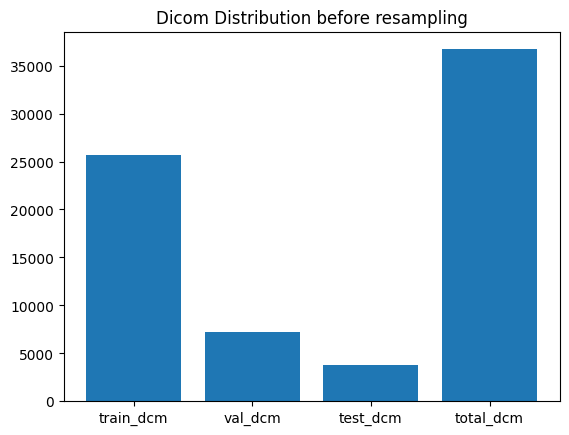

In [8]:
dcm_list = []
for key, value in eda_dict.items():
    if "dcm" in key:
        dcm_list.append([key, value])
dcm_list = np.array(dcm_list)

fig, ax = plt.subplots(1, 1)
ax.set_title("Dicom Distribution before resampling")
ax.bar(dcm_list[:, 0], dcm_list[:, 1].astype(int))

In [9]:
plot_eda_dict = {}
for name in ["total", "train", "val", "test"]:
    plot_eda_dict[name] = {}
    for key, value in eda_dict.items():
        if name in key and not "dcm" in key:
            plot_eda_dict[name][key] = value

In [10]:
def plot_distrib(dic, mode, split):
    plot = []
    for key, value in dic[split].items():
        if mode in key and not f"{split}_{mode}" in key:
            plot.append([key.replace(f"{split}_", ""), value])
    plot = np.array(plot)

    fig, ax = plt.subplots(1, 1)
    ax.set_title(f"{mode.title()} Distribution ({split.title()})")
    ax.bar(plot[:, 0], plot[:, 1].astype(float))

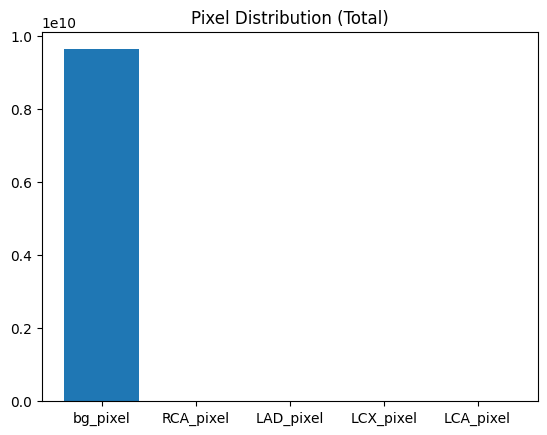

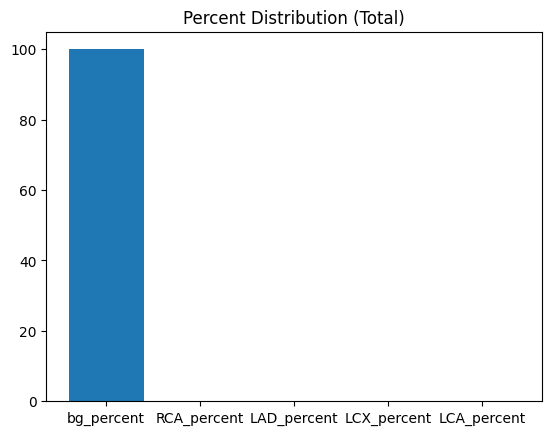

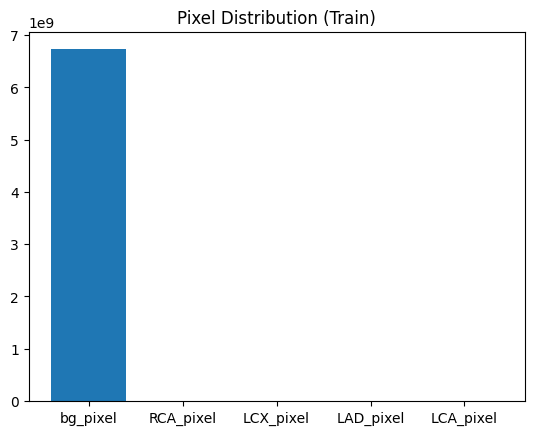

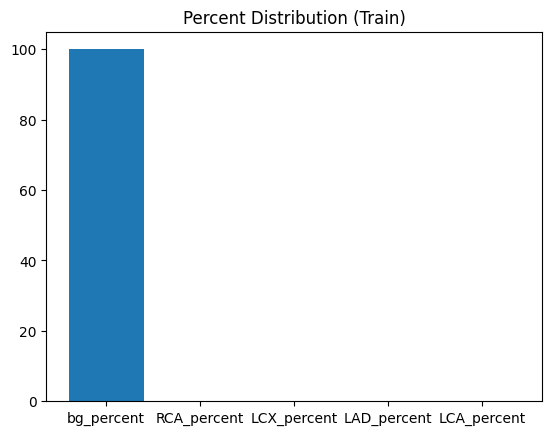

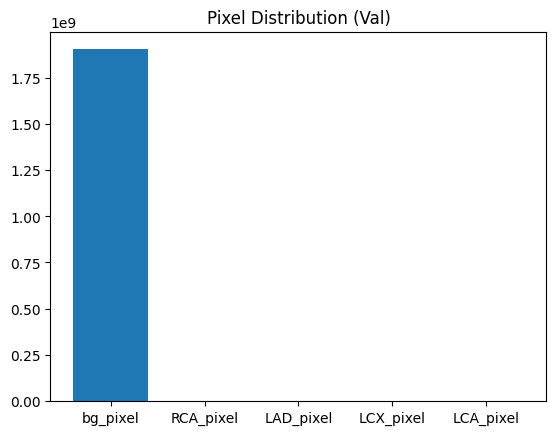

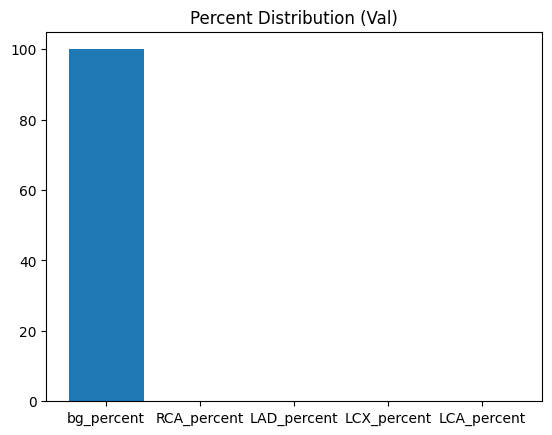

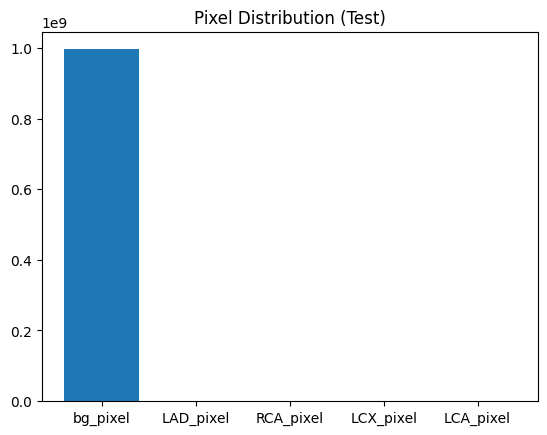

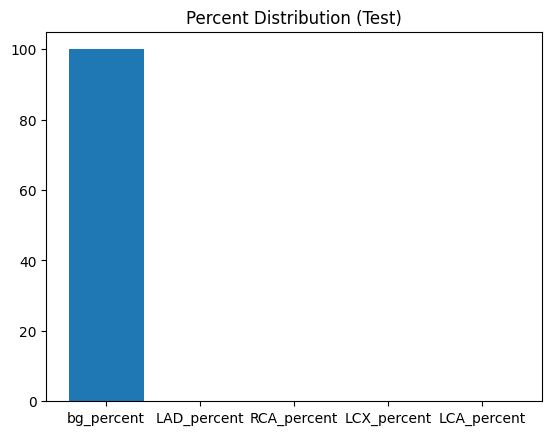

In [11]:
for split in ["total", "train", "val", "test"]:
    for mode in ["pixel", "percent"]:
        plot_distrib(plot_eda_dict, mode, split)

In [12]:
pprint(plot_eda_dict)

{'test': {'test_LAD_percent': 0.0010969387296311819,
          'test_LAD_pixel': 10930,
          'test_LCA_percent': 0.00013237531421624244,
          'test_LCA_pixel': 1319,
          'test_LCX_percent': 0.0006591668413739806,
          'test_LCX_pixel': 6568,
          'test_RCA_percent': 0.0013506497185156866,
          'test_RCA_pixel': 13458,
          'test_bg_percent': 99.99676086939641,
          'test_bg_pixel': 996377069,
          'test_pixel': 996409344},
 'total': {'total_LAD_percent': 0.001277769359339265,
           'total_LAD_pixel': 123034,
           'total_LCA_percent': 0.00017383246530731878,
           'total_LCA_pixel': 16738,
           'total_LCX_percent': 0.0007077924588137405,
           'total_LCX_pixel': 68152,
           'total_RCA_percent': 0.0013153025490644813,
           'total_RCA_pixel': 126648,
           'total_bg_percent': 99.99652530316776,
           'total_bg_pixel': 9628476692,
           'total_pixel': 9628811264},
 'train': {'train_LAD_perce